In [3]:
import pickle 
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rgnn_at_scale.models import GCN
from src.models.lp import LP
from rgnn_at_scale.attacks import FGSM
from tqdm import tqdm
from torch_sparse import SparseTensor
from matplotlib import pyplot as plt
import pandas as pd
import copy
from rgnn_at_scale.data import prep_graph, split
from src.helpers import delete_idx_from_data
from rgnn_at_scale.helper.io import Storage
device=0

from rgnn_at_scale.helper.utils import accuracy

## load model

In [4]:
def load_model(dataset='cora_ml', seed = 0, label='GCN', n_classes = 7, device = 0):
    if label == 'LP':
        model = Dummy_model(n_classes, device)
    else:
        store = Storage(cache_dir = '../cache')
        model_params = {"dataset": dataset, "binary_attr": False, "make_undirected": True, "seed": seed, "label": label}
        models_and_hyperparams = store.find_models('overrobust_final', model_params)
        model = models_and_hyperparams[0][0].to(device)
    return model 

# load dataset

In [9]:
def load_dataset(dataset, device=0, seed = 0):
    graph = prep_graph(dataset, device, dataset_root='datasets', make_undirected=True,
                           binary_attr=False, return_original_split=dataset.startswith('ogbn'))

    attr, adj, labels = graph[:3]
    if len(graph) == 3 or graph[3] is None:  # TODO: This is weird
        idx_test, idx_val, idx_train = split(labels.cpu().numpy(), n_per_class=40)
    else:
        idx_train, idx_val, idx_test = graph[3]['train'], graph[3]['valid'], graph[3]['test']
        
        #idx_keep = []
        #n_per_class=65
        #for c in labels.unique():
        #    idx = (labels[idx_test_orig] == c).nonzero().flatten()
        #    stop = min(len(idx), n_per_class)
        #    idx_keep.append(idx[torch.randperm(len(idx))[:stop]])
        #idx_test = torch.cat(idx_keep).cpu().numpy()
        
    _, adj_train = delete_idx_from_data(attr, adj, np.concatenate([idx_test, idx_val]))
    _, adj_val = delete_idx_from_data(attr, adj, idx_test)
    return attr, adj_val, adj, idx_train, idx_val, idx_test, labels

In [38]:
attr, adj_val, adj, idx_train, idx_val, idx_test, labels =  load_dataset('ogbn-arxiv') 
idx_keep = []
test_map = torch.zeros_like(labels)
test_map[idx_test]=1
for c in labels.unique():
    idx = ((labels == c) & test_map).nonzero().flatten()
    stop = min(len(idx), 40)
    idx_keep.append(idx[torch.randperm(len(idx))[:stop]])
idx_new = torch.cat(idx_keep).cpu().numpy()

In [ ]:
e

In [58]:


attr, adj_val, adj, idx_train, idx_val, idx_test, labels =  load_dataset('ogbn-arxiv') 
# compute n_per_class
n_total = 1500
bins = labels[idx_test].bincount()
bins_ratio = bins/bins.sum()
n_per_class = (n_total*bins_ratio).ceil()
# subsample test set
idx_keep = []
test_map = torch.zeros_like(labels)
test_map[idx_test]=1
for c,n in enumerate(n_per_class):
    print((c, n))
    idx = ((labels == c) & test_map).nonzero().flatten()
    idx_keep.append(idx[torch.randperm(len(idx))[:int(n)]])
idx_new = torch.cat(idx_keep).cpu().numpy()

(0, tensor(2., device='cuda:0'))
(1, tensor(6., device='cuda:0'))
(2, tensor(23., device='cuda:0'))
(3, tensor(21., device='cuda:0'))
(4, tensor(58., device='cuda:0'))
(5, tensor(39., device='cuda:0'))
(6, tensor(20., device='cuda:0'))
(7, tensor(5., device='cuda:0'))
(8, tensor(39., device='cuda:0'))
(9, tensor(11., device='cuda:0'))
(10, tensor(45., device='cuda:0'))
(11, tensor(8., device='cuda:0'))
(12, tensor(1., device='cuda:0'))
(13, tensor(20., device='cuda:0'))
(14, tensor(3., device='cuda:0'))
(15, tensor(3., device='cuda:0'))
(16, tensor(324., device='cuda:0'))
(17, tensor(7., device='cuda:0'))
(18, tensor(7., device='cuda:0'))
(19, tensor(13., device='cuda:0'))
(20, tensor(10., device='cuda:0'))
(21, tensor(2., device='cuda:0'))
(22, tensor(12., device='cuda:0'))
(23, tensor(25., device='cuda:0'))
(24, tensor(332., device='cuda:0'))
(25, tensor(15., device='cuda:0'))
(26, tensor(33., device='cuda:0'))
(27, tensor(64., device='cuda:0'))
(28, tensor(88., device='cuda:0'))
(29

In [56]:
n_per_class

tensor([  2.,   6.,  23.,  21.,  58.,  39.,  20.,   5.,  39.,  11.,  45.,   8.,
          1.,  20.,   3.,   3., 324.,   7.,   7.,  13.,  10.,   2.,  12.,  25.,
        332.,  15.,  33.,  64.,  88.,   4., 143.,  28.,   3.,   7.,  44.,   2.,
         20.,  15.,   7.,   9.], device='cuda:0')

In [46]:
labels[idx_test].bincount()

tensor([   54,   187,   733,   654,  1869,  1246,   622,   134,  1250,   345,
         1455,   239,     5,   628,    71,    87, 10477,   203,   209,   419,
          313,    51,   386,   808, 10740,   475,  1041,  2066,  2849,   120,
         4631,   892,    83,   220,  1414,    36,   627,   481,   214,   269],
       device='cuda:0')

In [47]:
labels[idx_train].bincount()

tensor([  437,   382,  3604,  1014,  2864,  2933,   703,   380,  4056,  2245,
         5182,   391,    21,  1290,   473,   248,  9998,   202,   402,  1873,
         1495,   304,  1268,  1539,  6989,   457,  2854,  1661, 16284,   239,
         4334,  1350,   270,   926,  5426,    75,  2506,  1615,  1100,  1551],
       device='cuda:0')

In [43]:
idx_test.shape

(48603,)

In [27]:
idx = (labels[idx_test] == 0).nonzero().flatten()
stop = min(len(idx), 40)
idx_keep.append(idx[torch.randperm(len(idx))[:stop]])

In [29]:
(labels == 0)

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [60]:
[x in idx_test for x in idx_new]
labels[idx_new].bincount()

tensor([  2,   6,  23,  21,  58,  39,  20,   5,  39,  11,  45,   8,   1,  20,
          3,   3, 324,   7,   7,  13,  10,   2,  12,  25, 332,  15,  33,  64,
         88,   4, 143,  28,   3,   7,  44,   2,  20,  15,   7,   9],
       device='cuda:0')

In [39]:
idx_new[0] in idx_test

True

In [41]:
len(idx_new)

1561

In [21]:
idx_test

array([   346,    398,    451, ..., 169340, 169341, 169342])

In [10]:
class Dummy_model():
    def __init__(self, n_classes, device = 0):
        self.out_dim = n_classes
        self.device = device

    def eval(self):
        pass

    def train(self): 
        pass

    def __call__(self, attr, adj):
        return torch.zeros(attr.shape[0], self.out_dim).to(self.device)

In [11]:
label = 'LP'
seed = 0
device = 0
dataset = 'cora_ml'
n_classes = 7
lp_params = {'num_layers': 1, 'alpha': 0.1, 'num_classes': 7}


def evaluate_lp(label, lp_params, dataset, device=0, seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # load dataset
    attr, adj_val, adj_test, idx_train, idx_val, idx_test, labels = load_dataset(dataset, device, seed)

    # load model 
    model = load_model(dataset, seed, label, lp_params['num_classes'], device)

    # construct LP
    lp = LP(**lp_params)
    mask = torch.zeros_like(labels)
    mask[idx_train]=1
    lp_input = {'y_true': labels[idx_train], 'mask': mask.bool()}

    # evaluate val acc + loss
    model.eval()
    logits = model(attr, adj_val)
    logits = lp.smooth(y_soft=logits, A = adj_val, **lp_input)
    acc_val = accuracy(logits, labels, idx_val)
    loss_val = F.cross_entropy(logits[idx_val], labels[idx_val])

    # evaluate test acc + loss
    model.eval()
    logits = model(attr, adj_test)
    logits = lp.smooth(y_soft=logits, A = adj_test, **lp_input)
    acc_test = accuracy(logits, labels, idx_test)
    loss_test = F.cross_entropy(logits[idx_test], labels[idx_test])

    return acc_test, loss_test.item(), acc_val, loss_val.item()

In [12]:
from itertools import product

grid = {'label': ['LP'],
        'seed': [0,1,5,6,7,8,9,10],
        'num_layers': [10],
        'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
        'num_classes': [7],
        'dataset': ['cora_ml']}

grid_list = (dict(zip(grid, vs)) for vs in product(*grid.values()))

df = pd.DataFrame()
for x in tqdm(grid_list):
    y = x.copy()
    x['lp_params'] = {'num_layers':x['num_layers'],
                     'alpha': x['alpha'],
                     'num_classes': x['num_classes']}
    x.pop('num_layers')
    x.pop('alpha')
    x.pop('num_classes')
    
    acc_test, loss_test, acc_val, loss_val = evaluate_lp(**x, device=0)
    y['acc_test'] = acc_test
    y['acc_val'] = acc_val
    y['loss_test'] = loss_test
    y['loss_val'] = loss_val
    df = df.append(y, ignore_index=True)

72it [00:10,  6.73it/s]


In [13]:
grid = {'label': ['LP'],
        'seed': [0,1,5,6,7,8,9,10],
        'num_layers': [10],
        'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
        'num_classes': [6],
        'dataset': ['citeseer']}

grid_list = (dict(zip(grid, vs)) for vs in product(*grid.values()))

#df = pd.DataFrame()
for x in tqdm(grid_list):
    y = x.copy()
    x['lp_params'] = {'num_layers':x['num_layers'],
                     'alpha': x['alpha'],
                     'num_classes': x['num_classes']}
    x.pop('num_layers')
    x.pop('alpha')
    x.pop('num_classes')
    
    acc_test, loss_test, acc_val, loss_val = evaluate_lp(**x, device=0)
    y['acc_test'] = acc_test
    y['acc_val'] = acc_val
    y['loss_test'] = loss_test
    y['loss_val'] = loss_val
    df = df.append(y, ignore_index=True)

72it [00:07,  9.82it/s]


In [14]:
from itertools import product

grid = {'label': ['GCN', 'LP'],
        'seed': [0,1,5,6,7],
        'num_layers': [10],
        'alpha': [0.1, 0.2, 0.5, 0.8], 
        'num_classes': [40],
        'dataset': ['ogbn-arxiv']}

grid = {'label': ['LP'],
        'seed': [0],
        'num_layers': [10],
        'alpha': [0.7], 
        'num_classes': [40],
        'dataset': ['ogbn-arxiv']}

grid_list = (dict(zip(grid, vs)) for vs in product(*grid.values()))

#df = pd.DataFrame()
for x in tqdm(grid_list):
    y = x.copy()
    x['lp_params'] = {'num_layers':x['num_layers'],
                     'alpha': x['alpha'],
                     'num_classes': x['num_classes']}
    x.pop('num_layers')
    x.pop('alpha')
    x.pop('num_classes')
    
    acc_test, loss_test, acc_val, loss_val = evaluate_lp(**x, device=0)
    y['acc_test'] = acc_test
    y['acc_val'] = acc_val
    y['loss_test'] = loss_test
    y['loss_val'] = loss_val
    df = df.append(y, ignore_index=True)

1it [00:00,  1.14it/s]


In [15]:
df

,acc_test,acc_val,alpha,dataset,label,loss_test,loss_val,num_classes,num_layers,seed
0,0.850000,0.832143,0.1,cora_ml,LP,1.906893,1.903485,7.0,10.0,0.0
1,0.850000,0.835714,0.2,cora_ml,LP,1.870653,1.864697,7.0,10.0,0.0
2,0.853571,0.835714,0.3,cora_ml,LP,1.837052,1.829328,7.0,10.0,0.0
3,0.864286,0.839286,0.4,cora_ml,LP,1.806125,1.797348,7.0,10.0,0.0
4,0.864286,0.832143,0.5,cora_ml,LP,1.778151,1.768980,7.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...
140,0.675000,0.695833,0.6,citeseer,LP,1.631629,1.618761,6.0,10.0,10.0
141,0.662500,0.691667,0.7,citeseer,LP,1.613935,1.599007,6.0,10.0,10.0
142,0.650000,0.695833,0.8,citeseer,LP,1.600053,1.584177,6.0,10.0,10.0
143,0.645833,0.683333,0.9,citeseer,LP,1.594280,1.580078,6.0,10.0,10.0


In [34]:
df_grouped = df.groupby(['dataset', 'num_layers', 'alpha', 'label']).mean()
df[df['dataset']=='cora_ml'].groupby(['num_layers', 'alpha', 'label']).mean()[['loss_val', 'acc_val']]

loss_val   acc_val
num_layers alpha label                    
10.0       0.1   LP     1.903997  0.806696
           0.2   LP     1.865742  0.808482
           0.3   LP     1.830869  0.809821
           0.4   LP     1.799303  0.812946
           0.5   LP     1.771318  0.813393
           0.6   LP     1.747497  0.817857
           0.7   LP     1.729336  0.817411
           0.8   LP     1.720197  0.814732
           0.9   LP     1.726946  0.807589

In [35]:
df[df['dataset']=='citeseer'].groupby(['num_layers', 'alpha', 'label']).mean()[['loss_val', 'acc_val']]

loss_val   acc_val
num_layers alpha label                    
10.0       0.1   LP     1.757943  0.661979
           0.2   LP     1.727363  0.664583
           0.3   LP     1.699559  0.665625
           0.4   LP     1.674080  0.668229
           0.5   LP     1.650692  0.668229
           0.6   LP     1.629468  0.670833
           0.7   LP     1.610809  0.672396
           0.8   LP     1.596252  0.670313
           0.9   LP     1.590087  0.664583

In [16]:
df[df['dataset']=='ogbn-arxiv'].groupby(['num_layers', 'alpha', 'label']).mean()[['loss_val', 'acc_val']]

,,,loss_val,acc_val
num_layers,alpha,label,,
10.0,0.7,LP,3.557057,0.670526


# dataset statistics 


In [74]:
from collections import Counter

def histplot_degree_distr(A, title="CORA", max_plot_deg=None):
    deg = np.sum(A, axis=1)
    max_deg = np.max(deg)
    print(f"Average Degree: {np.sum(deg) / deg.shape[0]:.2f}")
    print(f"Maximum Degree: {max_deg}")
    c = Counter(deg)
    ordered_c = [c[i] if i in c else 0 for i in range(max_deg+1)]
    fig, axs = plt.subplots(1, 1)
    #print(ordered_c)
    bins = [i for i in range(len(ordered_c)+1)] 
    #axs.hist(bins[:-1], bins, weights=ordered_c, color="blue", rwidth=0.7, alpha=0.5)
    axs.bar(bins[:-1], ordered_c, alpha=0.8)
    #counts, bins = np.histogram(deg)
    #axs.stairs(bins, counts)
    if max_plot_deg is not None:
        axs.set_xlim(left=0, right=max_plot_deg)
    axs.set_ylabel("Number of Nodes")
    axs.set_xlabel("Node Degree")
    axs.set_title(title)
    plt.show()
    return fig

In [129]:
dataset = 'citeseer'
attr, adj_val, adj, idx_train, idx_val, idx_test, labels = load_dataset(dataset, device=0, seed = 0)
labels.bincount()

tensor([115, 463, 388, 304, 532, 308], device='cuda:0')

In [101]:
def get_statistics(dataset):
    attr, adj_val, adj, idx_train, idx_val, idx_test, labels = load_dataset(dataset, device=0, seed = 0)
    #Nodes,
    n_nodes = attr.shape[0]
    #Edges, 
    n_edges = adj.sum()/2
    #Features,
    n_features = attr.shape[1]
    #Classes, 
    n_classes = len(labels.unique())
    #Average Node Degree, 
    avg_node_degree = adj.sum(dim=0).mean()
    #Average Same-Class Node Degree, 
    mask = labels.repeat(n_nodes, 1) == labels.repeat(n_nodes, 1).T
    avg_node_degree_same = (mask*adj.to_dense()).sum(dim=0).mean()
    #Average Different-Class Node Degree
    mask = labels.repeat(n_nodes, 1) != labels.repeat(n_nodes, 1).T
    avg_node_degree_other = (mask*adj.to_dense()).sum(dim=0).mean()
    return {'# Nodes': n_nodes,
            '# Edges': int(n_edges.cpu().numpy()),
            '# Features': n_features,
            '# Classes': n_classes,
            'Average Node Degree': float(avg_node_degree.cpu().numpy()),
            'Average Same-Class Node Degree': float(avg_node_degree_same.cpu().numpy()),
            'Average Different-Class Node Degree': float(avg_node_degree_other.cpu().numpy())}

In [128]:
df = pd.DataFrame()
datasets = [('cora_ml', 'Cora-ML'), ('citeseer', 'Citeseer')]
for dataset, title in datasets:
    data_dict = get_statistics(dataset)
    data_dict['Dataset'] = title
    df = df.append(data_dict, ignore_index=True)
cols = ['# Nodes','# Edges','# Features','# Classes','Average Node Degree','Average Same-Class Node Degree','Average Different-Class Node Degree']
df = df.round(decimals=2)
df[['# Nodes','# Edges','# Features','# Classes']] = df[['# Nodes','# Edges','# Features','# Classes']].astype(int)
df = df.set_index('Dataset')
print(df[cols].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  \# Nodes &  \# Edges &  \# Features &  \# Classes &  Average Node Degree &  Average Same-Class Node Degree &  Average Different-Class Node Degree \\
Dataset  &          &          &             &            &                      &                                 &                                      \\
\midrule
Cora-ML  &     2810 &     7981 &        2879 &          7 &                 5.68 &                            4.46 &                                 1.22 \\
Citeseer &     2110 &     3668 &        3703 &          6 &                 3.48 &                            2.56 &                                 0.92 \\
\bottomrule
\end{tabular}



Average Degree: 3.48
Maximum Degree: 99


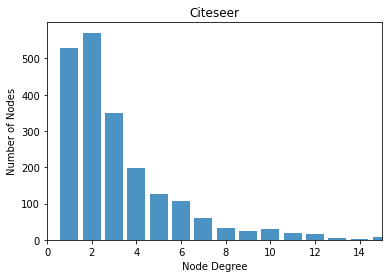

In [81]:
fig = histplot_degree_distr(adj.to_dense().cpu().int().numpy(), title='Citeseer', max_plot_deg=15)
fig.savefig('../results/images_overrobust/citeseer/degree_plot.pdf', bbox_inches='tight', format='pdf') 